In [1]:
import pickle
import rasterio
from rasterio.mask import mask
import os, sys
import numpy as np
import sklearn
from sklearn.cluster import MiniBatchKMeans, KMeans
import fiona
from matplotlib import pyplot as plt
from scipy.misc import bytescale
from mpl_toolkits.axes_grid1 import make_axes_locatable


SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)
    return fig.colorbar(mappable, cax=cax)

## write my own majority filter..
def majority_agg(arr, factor):
    
    # get the ranges of pixels to grab from planet
    row_sets = np.arange(0, arr.shape[0], factor)
    col_sets = np.arange(0, arr.shape[1], factor)
    
    # allocate new array
    new_arr = np.zeros((row_sets.size, col_sets.size))
    new_arr_std = np.zeros((row_sets.size, col_sets.size))
    new_arr_range = np.zeros((row_sets.size, col_sets.size))
    for i,r in enumerate(row_sets[:-2]):
        for j,c in enumerate(col_sets[:-2]):
            
            # get the start/stop for the slice
            row_start = int(row_sets[i])
            row_end = int(row_sets[i+1])
            col_start = int(col_sets[j])
            col_end = int(col_sets[j+1])
                        
            #get the pixels
            pixels = arr[row_start:row_end, col_start:col_end]
            
            # get the value (majority)
            val = np.argmax(np.bincount(pixels.ravel()))
            pix_std = np.std(pixels)
            pix_range = np.nanmax(pixels) - np.nanmin(pixels)
            
            new_arr[i,j] = val
            new_arr_std[i,j] = pix_std
            new_arr_range[i,j] = pix_range
    
    return new_arr, new_arr_std, new_arr_range

# function to plot rgb image with mask
def plot_rgb(arr):
    
    if arr.shape[-1] != 3:
        raise Exception('Input needs to be 3 band, and band channel needs to be last channel')
        
    if type(arr) is np.ma.MaskedArray:
        # build alpha channel        
        mask = np.ma.getmask(arr[:,:,0])
        mask = ~mask * 255
        
        # add the mask to the array (ise earthpy bytescale)
        plot_arr = np.dstack((bytescale(arr),mask))
        
        # plot it
        plt.imshow(plot_arr)
        plt.show()
        
    else: #no mask, no worries
        plt.imshow(plot_arr)
        
    return plot_arr

## convenience function to generate classification results
def classifyKMeansPlanetLandsat(clf, aoi_path, pl_path, l8_bands, save_files=False):
    
    ## load images as numpy arrays
    # load aoi
    with fiona.open(aoi_path, "r") as shapefile:
        geoms = [feature["geometry"] for feature in shapefile]

    # first planet
    with rasterio.open(pl_path, 'r') as src:
        pl_arr, pl_tf = rasterio.mask.mask(src, geoms, crop=True, nodata=0, all_touched=True)
        pl_meta = src.meta.copy()
        
    # metadata for writing
    print(pl_meta)
    pl_meta.update({"driver": "GTiff",
                     "count": 1,
                     "height": pl_arr.shape[1],
                     "width": pl_arr.shape[2],
                     "transform": pl_tf,
                     "dtype": rasterio.dtypes.ubyte})
    
    
    
    # move bands to back
    pl_arr = np.rollaxis(pl_arr, 0,3)

    # then landsat
    l_ls = []
    for lb in l8_bands:
        with rasterio.open(lb, 'r') as src:
            temp_arr, l8_tf = rasterio.mask.mask(src, geoms, crop=True, nodata=0, all_touched=True)
            temp_arr = temp_arr.squeeze()
            l8_meta = src.meta.copy()

        l_ls.append(temp_arr)
        
    

    # make list to array and roll bands to back
    l8_arr = np.ma.array(l_ls)
    l8_arr = np.rollaxis(l8_arr, 0,3)
    
    # metadata for writing
    l8_meta.update({"driver": "GTiff",
                     "count": 1,
                     "height": l8_arr.shape[0],
                     "width": l8_arr.shape[1],
                     "transform": l8_tf,
                     "dtype": rasterio.dtypes.ubyte,
                     "nodata": 0.0})

    ## explicitly set the mask
    l8_arr = np.ma.masked_equal(l8_arr, 0).astype('float32')/10000.
    pl_arr = np.ma.masked_equal(pl_arr, 0).astype('float32')/10000.

    pl_rgb = pl_arr[:,:,[2,1,0]]
    l8_rgb = l8_arr[:,:,[2,1,0]]
    
    # make the X array
    X_pl = pl_arr.reshape(-1,4)
    mask = np.ma.getmask(X_pl)
    mask_inds = np.where(~mask.all(axis=1))[0]
    X_pl_c = X_pl[mask_inds,:]

    # predict the array
    predictedClass = clf.predict(X_pl_c)

    # use the fit model
    predictedClass = predictedClass + 1
    predictedClass = np.expand_dims(predictedClass, axis=-1)

    # reshape to array
    pred_data_pl_pl = np.zeros((X_pl.shape[0], 1))
    pred_data_pl_pl[~mask_inds] = predictedClass
    pred_data_pl_pl = pred_data_pl_pl.reshape(pl_arr.shape[:2])
    pred_data_pl_pl = np.ma.masked_equal(pred_data_pl_pl, 0)
    pred_data_pl_pl = np.flipud(np.fliplr(pred_data_pl_pl))


    # do the same for landsat 8
    # make the X array
    X_l8 = l8_arr.reshape(-1,4)
    mask = np.ma.getmask(X_l8)
    mask_inds = np.where(~mask.all(axis=1))[0]
    X_l8_c = X_l8[mask_inds,:]

    # predict the array
    predictedClass = clf.predict(X_l8_c)

    # use the fit model
    predictedClass = predictedClass + 1
    predictedClass = np.expand_dims(predictedClass, axis=-1)

    # reshape to array
    pred_data_pl_l8 = np.zeros((X_l8.shape[0], 1))
    pred_data_pl_l8[~mask_inds] = predictedClass
    pred_data_pl_l8 = pred_data_pl_l8.reshape(l8_arr.shape[:2])
    pred_data_pl_l8 = np.ma.masked_equal(pred_data_pl_l8, 0)
    pred_data_pl_l8 = np.flipud(np.fliplr(pred_data_pl_l8))

    # do a majority resampling of the planet data to lansdat resolution
    pl_resamp_l8, pl_resamp_l8_std, pl_resamp_l8_range = majority_agg(pred_data_pl_pl.astype('int64'), 10)
    pl_resamp_l8 = np.ma.masked_equal(pl_resamp_l8, 0)
    
    if save_files:
        
        # get a base file name
        pl_base = '_'.join(os.path.basename(pl_path).split('_')[:4])
        l8_base = '_'.join(os.path.basename(l8_bands[0]).split('_')[:4])
        
        # output directory
        save_dir = 'kmeans_rasters'
        folder_name = '{}_{}_kmeans'.format(cl_base, date)
        if not os.path.exists(folder_name):
            os.mkdir(folder_name)
        
        # planet resolution filenames and arrays
        pl_tf_filenames = ['planet_{}_kmeans.tif'.format(pl_base)]
        pl_filenames = [os.path.join(save_dir, p) for p in pl_tf_filenames]
        pl_arrays = [pred_data_pl_pl]
        
        # iterate and save
        for arr, fname in zip(pl_arrays, pl_filenames):
            with rasterio.open(fname, 'w', **pl_meta) as dst:
                dst.write_band(1,arr.astype('uint8'))
                #dst.nodatavals = [arr.fill_value]
                
                
        
        # landsat resolution filenames and arrays
        l8_tf_filenames = ['planet_{}_kmeans_resamp.tif'.format(pl_base), 
                           'planet_{}_kmeans_resamp_std.tif'.format(pl_base), 
                           'planet_{}_kmeans_range.tif'.format(pl_base),
                           'landsat_{}_kmeans.tif'.format(l8_base)]
        l8_filenames = [os.path.join(save_dir, p) for p in l8_tf_filenames]        
        l8_arrays = [pl_resamp_l8, pl_resamp_l8_std, pl_resamp_l8_range, pred_data_pl_l8]
        
        # iterate and save
        for arr, fname in zip(l8_arrays, l8_filenames):
            with rasterio.open(fname, 'w', **l8_meta) as dst:
                
                # pad with zeros if necessary
                col_dif = l8_meta['width'] - arr.shape[1]
                row_dif = l8_meta['height'] - arr.shape[0]
                
                #((top, bottom), (left, right)) always add to bottom or right
                if (row_dif > 0) & (col_dif > 0):
                    arr = np.pad(arr, ((0, row_dif),(0, col_dif)), 'constant')
                    dst.write_band(1,arr.astype('uint8'))
                elif (row_dif > 0) & (col_dif < 0):
                    arr = np.pad(arr, ((0, row_dif),(0, 0)), 'constant')
                    arr = arr[:,:-col_dif]
                    dst.write_band(1,arr.astype('uint8'))
                elif (row_dif < 0) & (col_dif > 0):
                    arr = np.pad(arr, ((0, 0),(0, col_dif)), 'constant')
                    arr = arr[:-row_dif,:]
                    dst.write_band(1,arr.astype('uint8'))
                elif (row_dif < 0) & (col_dif < 0):
                    arr = arr[:-row_dif,:]
                    dst.write_band(1,arr.astype('uint8'))
                else:
                    dst.write_band(1,arr.astype('uint8'))
                
                print('saved ' + fname)
                
# with rasterio.open("tests/data/RGB.byte.tif") as src:
#     out_image, out_transform = mask(src, geoms, crop=True)
#     out_meta = src.meta.copy()

# out_meta.update({"driver": "GTiff",
#                  "height": out_image.shape[1],
#                  "width": out_image.shape[2],
#                  "transform": out_transform})

# with rasterio.open("/tmp/masked.tif", "w", **out_meta) as dest:
#     dest.write(out_image)
                
    
    # set up the return dictionary
    k_dict = {}
    k_dict['planet_rgb'] = pl_rgb
    k_dict['landsat_rgb'] = l8_rgb
    k_dict['planet_arr'] = pl_arr
    k_dict['landsat_arr'] = l8_arr
    k_dict['planet_kmeans'] = pred_data_pl_pl
    k_dict['landsat_kmeans'] = pred_data_pl_l8
    k_dict['planet_kmeans_resamp'] = pl_resamp_l8
    k_dict['planet_kmeans_resamp_std'] = pl_resamp_l8_std
    k_dict['planet_kmeans_resamp_range'] = pl_resamp_l8_range
    
    return k_dict

## convenience function to generate classification results
def classifyKMeansPlanetLandsat_save(clf, cl_base, aoi_path, pl_path, l8_bands, save_files=False, app=''):
    
    ## load images as numpy arrays
    # load aoi
    with fiona.open(aoi_path, "r") as shapefile:
        geoms = [feature["geometry"] for feature in shapefile]

    # first planet
    with rasterio.open(pl_path, 'r') as src:
        pl_arr, pl_tf = rasterio.mask.mask(src, geoms, crop=True, nodata=0, all_touched=True)
        pl_meta = src.meta.copy()
        
    # metadata for writing
    print(pl_meta)
    pl_meta.update({"driver": "GTiff",
                     "count": 1,
                     "height": pl_arr.shape[1],
                     "width": pl_arr.shape[2],
                     "transform": pl_tf,
                     "dtype": rasterio.dtypes.ubyte})
    
    
    
    # move bands to back
    pl_arr = np.rollaxis(pl_arr, 0,3)

    # then landsat
    l_ls = []
    for lb in l8_bands:
        with rasterio.open(lb, 'r') as src:
            temp_arr, l8_tf = rasterio.mask.mask(src, geoms, crop=True, nodata=0, all_touched=True)
            temp_arr = temp_arr.squeeze()
            l8_meta = src.meta.copy()

        l_ls.append(temp_arr)
        
    

    # make list to array and roll bands to back
    l8_arr = np.ma.array(l_ls)
    l8_arr = np.rollaxis(l8_arr, 0,3)
    
    # metadata for writing
    l8_meta.update({"driver": "GTiff",
                     "count": 1,
                     "height": l8_arr.shape[0],
                     "width": l8_arr.shape[1],
                     "transform": l8_tf,
                     "dtype": rasterio.dtypes.ubyte,
                     "nodata": 0.0})

    ## explicitly set the mask
    l8_arr = np.ma.masked_equal(l8_arr, 0).astype('float32')/10000.
    pl_arr = np.ma.masked_equal(pl_arr, 0).astype('float32')/10000.

    pl_rgb = pl_arr[:,:,[2,1,0]]
    l8_rgb = l8_arr[:,:,[2,1,0]]
    
    # make the X array
    X_pl = pl_arr.reshape(-1,4)
    mask = np.ma.getmask(X_pl)
    mask_inds = np.where(~mask.all(axis=1))[0]
    X_pl_c = X_pl[mask_inds,:]

    # predict the array
    predictedClass = clf.predict(X_pl_c)

    # use the fit model
    predictedClass = predictedClass + 1
    predictedClass = np.expand_dims(predictedClass, axis=-1)

    # reshape to array
    pred_data_pl_pl = np.zeros((X_pl.shape[0], 1))
    pred_data_pl_pl[~mask_inds] = predictedClass
    pred_data_pl_pl = pred_data_pl_pl.reshape(pl_arr.shape[:2])
    pred_data_pl_pl = np.ma.masked_equal(pred_data_pl_pl, 0)
    pred_data_pl_pl = np.flipud(np.fliplr(pred_data_pl_pl))


    # do the same for landsat 8
    # make the X array
    X_l8 = l8_arr.reshape(-1,4)
    mask = np.ma.getmask(X_l8)
    mask_inds = np.where(~mask.all(axis=1))[0]
    X_l8_c = X_l8[mask_inds,:]

    # predict the array
    predictedClass = clf.predict(X_l8_c)

    # use the fit model
    predictedClass = predictedClass + 1
    predictedClass = np.expand_dims(predictedClass, axis=-1)

    # reshape to array
    pred_data_pl_l8 = np.zeros((X_l8.shape[0], 1))
    pred_data_pl_l8[~mask_inds] = predictedClass
    pred_data_pl_l8 = pred_data_pl_l8.reshape(l8_arr.shape[:2])
    pred_data_pl_l8 = np.ma.masked_equal(pred_data_pl_l8, 0)
    pred_data_pl_l8 = np.flipud(np.fliplr(pred_data_pl_l8))

    # do a majority resampling of the planet data to lansdat resolution
    pl_resamp_l8, pl_resamp_l8_std, pl_resamp_l8_range = majority_agg(pred_data_pl_pl.astype('int64'), 10)
    pl_resamp_l8 = np.ma.masked_equal(pl_resamp_l8, 0)
    
    if save_files:
        
        # get a base file name
        pl_base = '_'.join(os.path.basename(pl_path).split('_')[:4])
        l8_base = '_'.join(os.path.basename(l8_bands[0]).split('_')[:4])
        
        # output directory
        #save_dir = 'kmeans_rasters'
        date = pl_base.split('_')[0]
        folder_name = '{}_{}_{}_kmeans'.format(cl_base, date, app)
        if not os.path.exists(folder_name):
            os.mkdir(folder_name)
        
        # planet resolution filenames and arrays
        pl_tf_filenames = ['planet_{}_{}_kmeans.tif'.format(cl_base, pl_base)]
        pl_filenames = [os.path.join(folder_name, p) for p in pl_tf_filenames]
        pl_arrays = [pred_data_pl_pl]
        
        # iterate and save
        for arr, fname in zip(pl_arrays, pl_filenames):
            with rasterio.open(fname, 'w', **pl_meta) as dst:
                dst.write_band(1,arr.astype('uint8'))
                #dst.nodatavals = [arr.fill_value]
                
                
        
        # landsat resolution filenames and arrays
        l8_tf_filenames = ['planet_{}_{}_kmeans_resamp.tif'.format(cl_base, pl_base), 
                           'planet_{}_{}_kmeans_resamp_std.tif'.format(cl_base, pl_base), 
                           'planet_{}_{}_kmeans_range.tif'.format(cl_base, pl_base),
                           'landsat_{}_{}_kmeans.tif'.format(cl_base, l8_base)]
        l8_filenames = [os.path.join(folder_name, p) for p in l8_tf_filenames]        
        l8_arrays = [pl_resamp_l8, pl_resamp_l8_std, pl_resamp_l8_range, pred_data_pl_l8]
        
        # iterate and save
        for arr, fname in zip(l8_arrays, l8_filenames):
            with rasterio.open(fname, 'w', **l8_meta) as dst:
                
                # pad with zeros if necessary
                col_dif = l8_meta['width'] - arr.shape[1]
                row_dif = l8_meta['height'] - arr.shape[0]
                
                #((top, bottom), (left, right)) always add to bottom or right
                if (row_dif > 0) & (col_dif > 0):
                    arr = np.pad(arr, ((0, row_dif),(0, col_dif)), 'constant')
                    dst.write_band(1,arr.astype('uint8'))
                elif (row_dif > 0) & (col_dif < 0):
                    arr = np.pad(arr, ((0, row_dif),(0, 0)), 'constant')
                    arr = arr[:,:-col_dif]
                    dst.write_band(1,arr.astype('uint8'))
                elif (row_dif < 0) & (col_dif > 0):
                    arr = np.pad(arr, ((0, 0),(0, col_dif)), 'constant')
                    arr = arr[:-row_dif,:]
                    dst.write_band(1,arr.astype('uint8'))
                elif (row_dif < 0) & (col_dif < 0):
                    arr = arr[:-row_dif,:]
                    dst.write_band(1,arr.astype('uint8'))
                else:
                    dst.write_band(1,arr.astype('uint8'))
                
                print('saved ' + fname)
                
# with rasterio.open("tests/data/RGB.byte.tif") as src:
#     out_image, out_transform = mask(src, geoms, crop=True)
#     out_meta = src.meta.copy()

# out_meta.update({"driver": "GTiff",
#                  "height": out_image.shape[1],
#                  "width": out_image.shape[2],
#                  "transform": out_transform})

# with rasterio.open("/tmp/masked.tif", "w", **out_meta) as dest:
#     dest.write(out_image)
                
    
    # set up the return dictionary
    k_dict = {}
    k_dict['planet_rgb'] = pl_rgb
    k_dict['landsat_rgb'] = l8_rgb
    k_dict['planet_arr'] = pl_arr
    k_dict['landsat_arr'] = l8_arr
    k_dict['planet_kmeans'] = pred_data_pl_pl
    k_dict['landsat_kmeans'] = pred_data_pl_l8
    k_dict['planet_kmeans_resamp'] = pl_resamp_l8
    k_dict['planet_kmeans_resamp_std'] = pl_resamp_l8_std
    k_dict['planet_kmeans_resamp_range'] = pl_resamp_l8_range
    
    return k_dict

## Load the k-means classifiers and use the n_classes=7 classifier

In [3]:
l8_kmeans_pickle_file = 'l8_kmeans_classifier_list_3_9_classes_SJER_sept2017.pickle'
pl_kmeans_pickle_file = 'pl_kmeans_classifier_list_3_9_classes_SJER_sept2017.pickle'

with open(l8_kmeans_pickle_file, 'rb') as fi:
    l8_kmeans = pickle.load(fi)
    
with open(pl_kmeans_pickle_file, 'rb') as fi:
    pl_kmeans = pickle.load(fi)
    
# pick out the k=9 classifiers
clf_l8 = l8_kmeans[6]
clf_pl = pl_kmeans[6]



In [4]:
# specify some shape files
sjer_aoi_shp = '../shp/planet_sub_mosaic_intersect_SJER_AOI.shp'
sjer_bound_shp = '../shp/Export_Output.shp'

# specify some image files for March 12
# planet_mar12 = '../march_2017_planet_scenes/20170312_180045_0e3a/20170312_180045_0e3a_3B_AnalyticMS_SR.tif'
# planet_mar12_b = '../march_2017_planet_scenes/20170312_180046_0e3a/20170312_180046_0e3a_3B_AnalyticMS_SR.tif'

# planet and ladsat paths for late september
planet_sep22 = '../september_2017_planet_scenes/20170922_180031_1038/20170922_180031_1038_3B_AnalyticMS_SR.tif'
l8_sep24_base = '../landsat8/SR/LC080420342017092001T1-SC20180524161437/LC08_L1TP_042034_20170920_20171012_01_T1_sr_'
l8_sep24_bands = [l8_sep24_base + b + '.tif' for b in ['band2', 'band3', 'band4', 'band5']]

# planet scenes for march 06
# planet_mar06_a = '../march_2017_planet_scenes/20170306_175957_0e19/20170306_175957_0e19_3B_AnalyticMS_SR.tif'
# planet_mar06_b = '../march_2017_planet_scenes/20170306_175958_0e19/20170306_175958_0e19_3B_AnalyticMS_SR.tif'
# planet_mar06_c = '../march_2017_planet_scenes/20170306_175959_0e19/20170306_175959_0e19_3B_AnalyticMS_SR.tif'

# planet scenes for march 29
# planet_mar28_a = '../march_2017_planet_scenes/20170329_180112_0e1f/20170329_180112_0e1f_3B_AnalyticMS_SR.tif'
# planet_mar28_b = '../march_2017_planet_scenes/20170329_180113_0e1f/20170329_180113_0e1f_3B_AnalyticMS_SR.tif'

# landsat bands for march 12
# l8_mar12_base = '../landsat8/SR/LC080420342017031201T1-SC20180503152939/LC08_L1TP_042034_20170312_20170317_01_T1_sr_'
# l8_mar12_bands = [l8_mar12_base + b + '.tif' for b in ['band2', 'band3', 'band4', 'band5']]
# l8_mar12_bands

# landsat scenes for march 28
# l8_mar28_base = '../landsat8/SR/LC080420342017032801T1-SC20180503155005/LC08_L1TP_042034_20170328_20170414_01_T1_sr_'
# l8_mar28_bands = [l8_mar28_base + b + '.tif' for b in ['band2', 'band3', 'band4', 'band5']]
# l8_mar28_bands

## Try the classifier on the other scene from March 12

In [5]:
## run the classifier from mar12 on mar12_b and plot
for cl, cl_b in zip([clf_pl, clf_l8], ['pl_k7', 'l8_k7']):
    
    res_mar12_b = classifyKMeansPlanetLandsat_save(cl, cl_b, sjer_aoi_shp, planet_sep22, l8_sep24_bands, True, app='c')

# fig, ax = plt.subplots(5,1, figsize = (40,40))
# c = ax[0].imshow(res_mar12_b['planet_kmeans'])
# ax[0].set_title('PlanetScope K-means classifier')
# colorbar(c)
# c = ax[1].imshow(res_mar12_b['planet_kmeans_resamp'], vmin=1)
# ax[1].set_title('PlanetScope K-means resampled to Landsat Resolution')
# colorbar(c)
# c = ax[2].imshow(res_mar12_b['planet_kmeans_resamp_std'], vmin=1)
# ax[2].set_title('PlanetScope K-means resampled to Landsat Resolution STD')
# colorbar(c)
# c = ax[3].imshow(res_mar12_b['planet_kmeans_resamp_range'], vmin=1)
# ax[3].set_title('PlanetScope K-means resampled to Landsat Resolution RANGE')
# colorbar(c)
# c = ax[4].imshow(res_mar12_b['landsat_kmeans'])
# ax[4].set_title('Landsat (Planet Classifier) K-means')
# colorbar(c)
# plt.show()


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 9115, 'height': 4818, 'count': 4, 'crs': CRS({'init': 'epsg:32611'}), 'transform': (250374.0, 3.0, 0.0, 4117017.0, 0.0, -3.0), 'affine': Affine(3.0, 0.0, 250374.0,
       0.0, -3.0, 4117017.0)}


C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:37: UserWarning: Warning: converting a masked element to nan.
C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:38: UserWarning: Warning: converting a masked element to nan.


saved pl_k7_20170922_c_kmeans\planet_pl_k7_20170922_180031_1038_3B_kmeans_resamp.tif
saved pl_k7_20170922_c_kmeans\planet_pl_k7_20170922_180031_1038_3B_kmeans_resamp_std.tif
saved pl_k7_20170922_c_kmeans\planet_pl_k7_20170922_180031_1038_3B_kmeans_range.tif
saved pl_k7_20170922_c_kmeans\landsat_pl_k7_LC08_L1TP_042034_20170920_kmeans.tif
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 9115, 'height': 4818, 'count': 4, 'crs': CRS({'init': 'epsg:32611'}), 'transform': (250374.0, 3.0, 0.0, 4117017.0, 0.0, -3.0), 'affine': Affine(3.0, 0.0, 250374.0,
       0.0, -3.0, 4117017.0)}
saved l8_k7_20170922_c_kmeans\planet_l8_k7_20170922_180031_1038_3B_kmeans_resamp.tif
saved l8_k7_20170922_c_kmeans\planet_l8_k7_20170922_180031_1038_3B_kmeans_resamp_std.tif
saved l8_k7_20170922_c_kmeans\planet_l8_k7_20170922_180031_1038_3B_kmeans_range.tif
saved l8_k7_20170922_c_kmeans\landsat_l8_k7_LC08_L1TP_042034_20170920_kmeans.tif


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 9304, 'height': 4948, 'count': 4, 'crs': CRS({'init': 'epsg:32611'}), 'transform': (238989.0, 3.0, 0.0, 4119177.0, 0.0, -3.0), 'affine': Affine(3.0, 0.0, 238989.0,
       0.0, -3.0, 4119177.0)}


C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:37: UserWarning: Warning: converting a masked element to nan.
C:\anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel\__main__.py:38: UserWarning: Warning: converting a masked element to nan.


saved pl_k7_20170329_kmeans\planet_pl_k7_20170329_180112_0e1f_3B_kmeans_resamp.tif
saved pl_k7_20170329_kmeans\planet_pl_k7_20170329_180112_0e1f_3B_kmeans_resamp_std.tif
saved pl_k7_20170329_kmeans\planet_pl_k7_20170329_180112_0e1f_3B_kmeans_range.tif
saved pl_k7_20170329_kmeans\landsat_pl_k7_LC08_L1TP_042034_20170328_kmeans.tif
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 9304, 'height': 4948, 'count': 4, 'crs': CRS({'init': 'epsg:32611'}), 'transform': (238989.0, 3.0, 0.0, 4119177.0, 0.0, -3.0), 'affine': Affine(3.0, 0.0, 238989.0,
       0.0, -3.0, 4119177.0)}
saved l8_k7_20170329_kmeans\planet_l8_k7_20170329_180112_0e1f_3B_kmeans_resamp.tif
saved l8_k7_20170329_kmeans\planet_l8_k7_20170329_180112_0e1f_3B_kmeans_resamp_std.tif
saved l8_k7_20170329_kmeans\planet_l8_k7_20170329_180112_0e1f_3B_kmeans_range.tif
saved l8_k7_20170329_kmeans\landsat_l8_k7_LC08_L1TP_042034_20170328_kmeans.tif
March28 Scene A


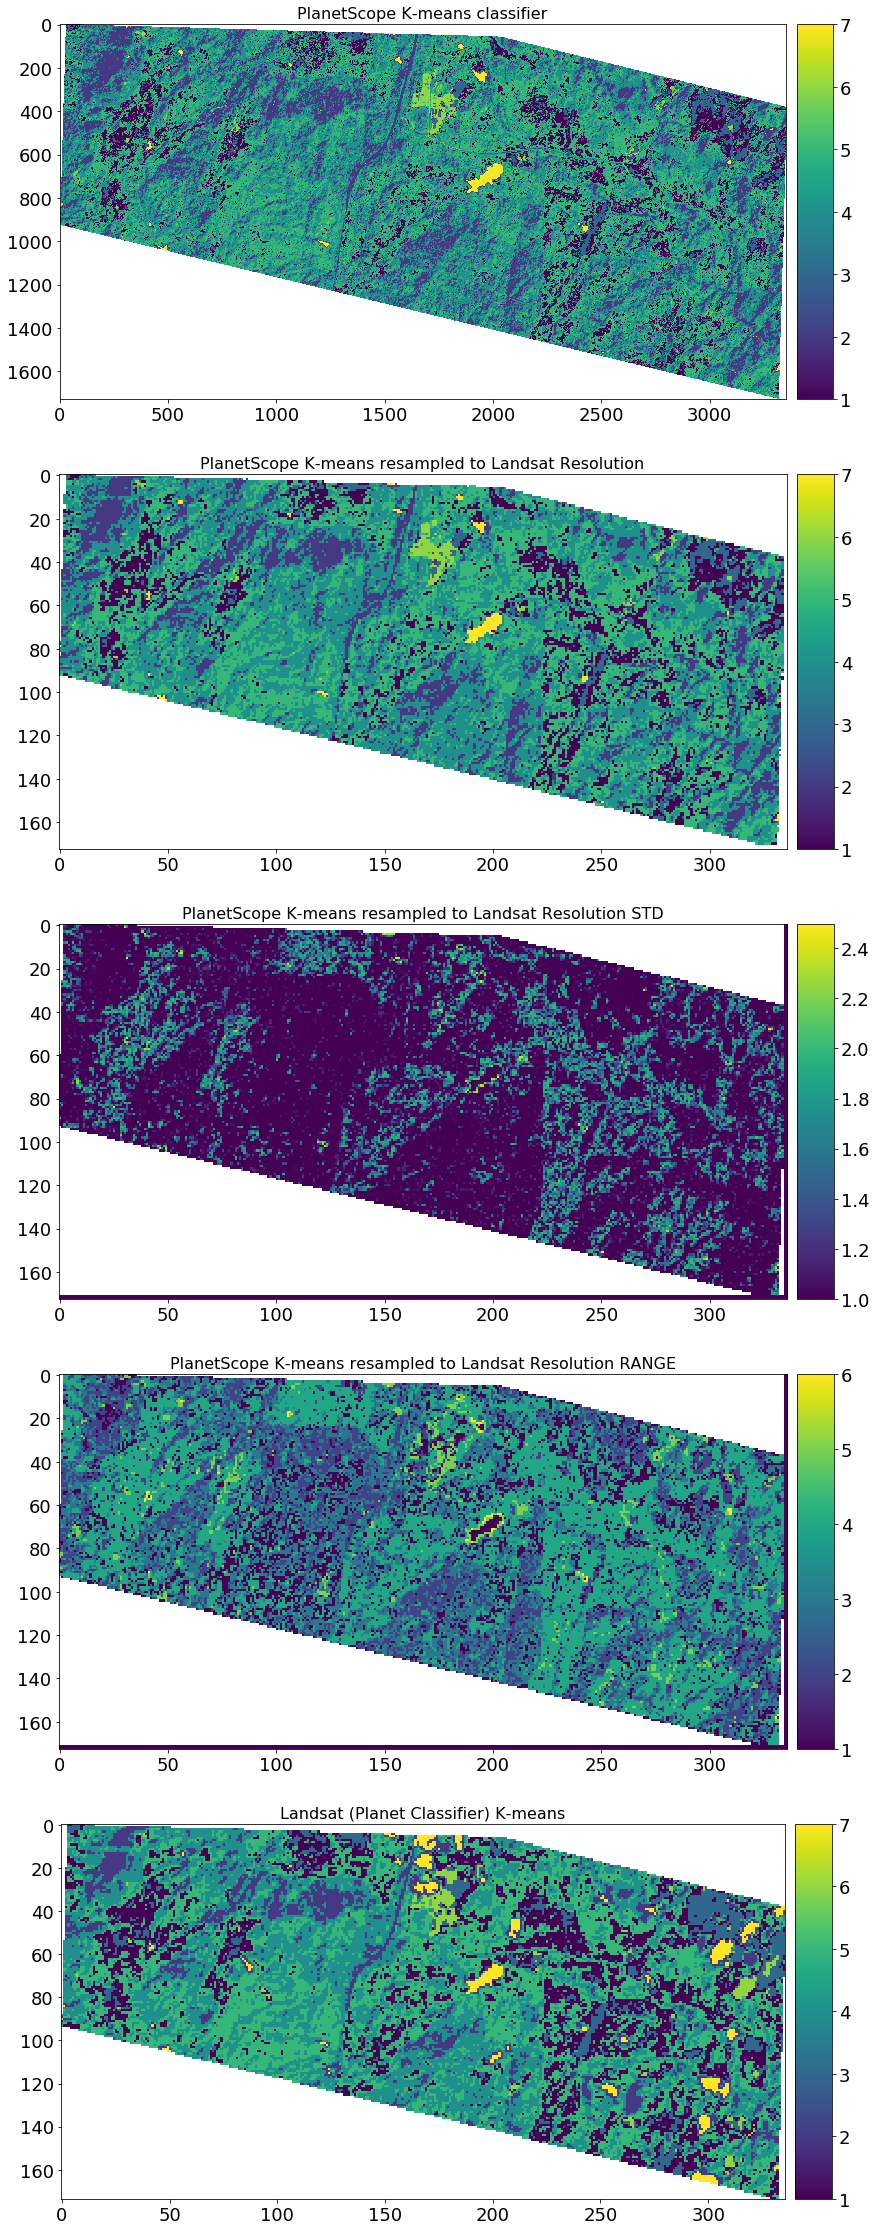

In [20]:
## run the classifier from mar12 on the data from mar28
for cl, cl_b in zip([clf_pl, clf_l8], ['pl_k7', 'l8_k7']):
    
    res_mar28_a = classifyKMeansPlanetLandsat_save(cl, cl_b, sjer_aoi_shp, planet_mar28_a, l8_mar28_bands, True)

print('March28 Scene A')
fig, ax = plt.subplots(5,1, figsize = (40,40))
c = ax[0].imshow(res_mar28_a['planet_kmeans'])
ax[0].set_title('PlanetScope K-means classifier')
colorbar(c)
c = ax[1].imshow(res_mar28_a['planet_kmeans_resamp'], vmin=1)
ax[1].set_title('PlanetScope K-means resampled to Landsat Resolution')
colorbar(c)
c = ax[2].imshow(res_mar28_a['planet_kmeans_resamp_std'], vmin=1)
ax[2].set_title('PlanetScope K-means resampled to Landsat Resolution STD')
colorbar(c)
c = ax[3].imshow(res_mar28_a['planet_kmeans_resamp_range'], vmin=1)
ax[3].set_title('PlanetScope K-means resampled to Landsat Resolution RANGE')
colorbar(c)
c = ax[4].imshow(res_mar28_a['landsat_kmeans'])
ax[4].set_title('Landsat (Planet Classifier) K-means')
colorbar(c)
plt.show()

## this image strip doesn't intersect the SJER PL intersection AOI
# res_mar28_b = classifyKMeansPlanetLandsat(clf_pl, sjer_aoi_shp, planet_mar28_b, l8_mar28_bands)

# print('March28 Scene B')
# fig, ax = plt.subplots(3,1, figsize = (40,40))
# c = ax[0].imshow(res_mar28_b['planet_kmeans'])
# ax[0].set_title('PlanetScope K-means classifier')
# colorbar(c)
# c = ax[1].imshow(res_mar28_b['planet_kmeans_resamp'], vmin=1)
# ax[1].set_title('PlanetScope K-means resampled to Landsat Resolution')
# colorbar(c)
# c = ax[2].imshow(res_mar28_b['planet_kmeans_resamp STD'], vmin=1)
# ax[1].set_title('PlanetScope K-means resampled to Landsat Resolution')
# colorbar(c)
# c = ax[3].imshow(res_mar28_b['planet_kmeans_resamp RANGE'], vmin=1)
# ax[1].set_title('PlanetScope K-means resampled to Landsat Resolution')
# colorbar(c)
# c = ax[4].imshow(res_mar28_b['landsat_kmeans'])
# ax[4].set_title('Landsat (Planet Classifier) K-means')
# colorbar(c)
# plt.show()



In [11]:
clf_pl

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=10, tol=0.0001, verbose=0)